# Device function factory

<a href="https://colab.research.google.com/github/mark-hobbs/articles/blob/main/cuda/device-function-factory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!uv pip install -q --system numba-cuda==0.15.0

import matplotlib.pyplot as plt
import numpy as np
from numba import  njit, prange, config
config.CUDA_ENABLE_PYNVJITLINK = 1

try:
    import google.colab
    !git clone https://github.com/mark-hobbs/articles.git
    import os
    os.chdir('articles/cuda')  # Navigate to the cuda subdirectory
except ImportError:
    pass  # Already local, no need to clone

import utils

Cloning into 'articles'...
remote: Enumerating objects: 618, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 618 (delta 87), reused 74 (delta 24), pack-reused 464 (from 1)
Receiving objects: 100% (618/618), 101.18 MiB | 35.59 MiB/s, done.
Resolving deltas: 100% (301/301), done.


### Motivation

When working with multiple models that have different parameter requirements, a key challenge is keeping the **call interface** consistent.

For example, consider the challenge of switching between polynomial models:

* A **second-order polynomial** requires `compute_polynomial(x, a, b, c)`
* A **third-order polynomial** requires `compute_polynomial(x, a, b, c, d)`

If these parameter differences are exposed directly, every place where `compute_polynomial` is used must be updated whenever the model changes. This leads to rigid and error-prone code.

A **function factory** solves this problem by **decoupling** the model configuration from its usage. The factory embeds the model parameters when the function is created, and the returned function always has the same interface:

```python
compute_polynomial = make_polynomial_function(a, b, c)
y = compute_polynomial(x)  # consistent, regardless of model
```

This pattern is widely applicable. For example, different material models (e.g. linear elastic, plasticity, viscoelasticity) often require different parameters. By using a factory, the solver can always call:

```python
stress = material_model(strain)
```

without needing to know which material model is being used or how many parameters it requires.

In [74]:
np.random.seed(42)

n_elements = 1000000

In [75]:
def linear(x, a, b):
    """
    First-order polynomial
    """
    return (a * x) + b

In [76]:
def quadratic(x, a, b, c):
    """
    Second-order polynomial
    """
    return (a * x**2) + (b * x) + c

In [77]:
@njit
def cubic(x, a, b, c, d):
    """
    Third-order polynomial
    """
    return (a * x**3) + (b * x**2) + (c * x) + d

In [78]:
def make_polynomial_function_cpu(a, b, c, d):
    """
    Function factory
    """
    @njit
    def polynomial_function(x):
        """
        Wrapper
        """
        return cubic(x, a, b, c, d)
    return polynomial_function

In [79]:
calculate_polynomial = make_polynomial_function_cpu(a=5, b=2, c=1, d=10)

In [80]:
@utils.profile(runs=10)
@njit
def calculate_y(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = np.sin(x[i]) * calculate_polynomial(x[i])
    return y

In [81]:
x = np.linspace(-100, 100, n_elements)
y = calculate_y(x)

Function 'calculate_y' executed 10 time(s)
Average execution time: 0.0365 seconds
Min: 0.0134s, Max: 0.2376s



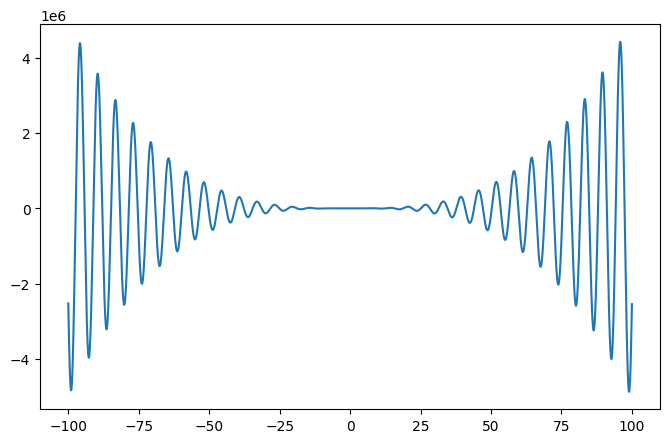

In [82]:
plt.figure(figsize=(8, 5))
plt.plot(x, y)

## Numba CUDA

In [83]:
import math
from numba import cuda, float32

In [84]:
utils.get_cuda_device_info()

CUDA Device Information:
----------------------------------------
CUDA Runtime Version:          12.6
Device Name:                   Tesla T4                                                                                                                        
Compute Capability:            (7, 5)

Memory:
Total Memory:                  15.83 GB
Free Memory:                   15.69 GB

Compute Resources:
Streaming Multiprocessors:     40
Max Threads per Block:         1024

Grid Limitations:
Max Grid Dimensions X:         2147483647
Max Grid Dimensions Y:         65535
Max Grid Dimensions Z:         65535

Additional Characteristics:
Warp Size:                     32
Clock Rate:                    1.59 GHz
Memory Clock Rate:             5.00 GHz


In [85]:
@cuda.jit(device=True)
def cubic(x, a, b, c, d):
    """
    Third-order polynomial
    """
    return (a * x**3) + (b * x**2) + (c * x) + d

In [86]:
def make_polynomial_function_gpu(a, b, c, d):
    """
    Function factory
    """

    @cuda.jit
    def calculate_y_kernel(x, y):
        i = cuda.grid(1)
        if i < x.size:
            y[i] = math.sin(x[i]) * cubic(x[i], a, b, c, d)

    def calculate_y_gpu(x, y):
        THREADS_PER_BLOCK = 256
        BLOCKS_PER_GRID = (x.size + THREADS_PER_BLOCK - 1) // THREADS_PER_BLOCK
        calculate_y_kernel[BLOCKS_PER_GRID, THREADS_PER_BLOCK](x, y)

    return calculate_y_gpu

In [87]:
calculate_polynomial = make_polynomial_function_gpu(a=5, b=2, c=1, d=10)

In [88]:
x_d = cuda.to_device(x.astype(np.float32))
y_d = cuda.device_array_like(x)

In [89]:
import time

def benchmark_kernel(x, y, num_runs=100):

    # Warm up the kernel
    for _ in range(5):
        calculate_polynomial(x, y)

    cuda.synchronize()

    start = time.perf_counter()

    for _ in range(num_runs):
        calculate_polynomial(x, y)

    cuda.synchronize()

    end = time.perf_counter()

    avg = (end - start) / num_runs
    return avg, y.copy_to_host()

In [90]:
cuda_event_time, result = benchmark_kernel(x_d, y_d)
print(f"Kernel executed in {cuda_event_time:.4f} seconds")

Kernel executed in 0.0002 seconds


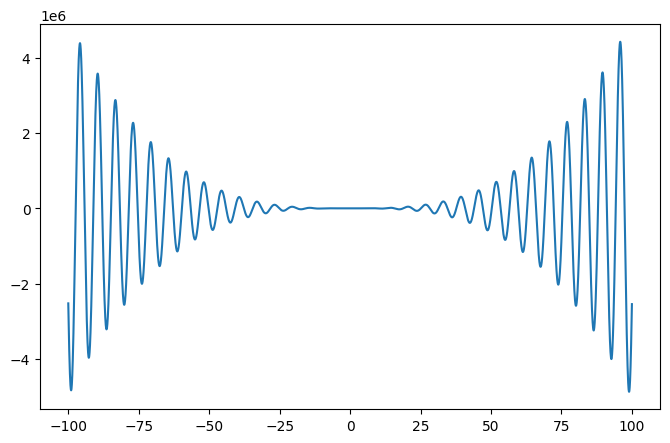

In [91]:
plt.figure(figsize=(8, 5))
plt.plot(x, result)